# Using ConvNet to classify FHR CTG traces as being from infants with abnormal pH

## Load packages

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statistics import mode
from tensorflow import keras
from tensorflow.keras import layers

2023-11-03 12:13:23.811460: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 12:13:23.882151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 12:13:23.882210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 12:13:23.882263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 12:13:23.896771: I tensorflow/core/platform/cpu_feature_g

## Set model parameters

In [2]:
# Set outcome
outcome = 'pH'

# Threshold to define outcome as abnormal or not
outcome_threshold = 7.2

## Load data

In [3]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [4]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [5]:
# Load meta data and transform
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')
metadata.head()

,1347,2040,1054,1247,1127,1231,1318,1481,1358,1243,...,1421,1236,1256,1435,1404,1118,1018,1447,1152,1229
parameter,,,,,,,,,,,,,,,,,,,,,
pH,7.14,7.23,7.19,7.32,7.35,7.28,7.22,7.29,7.14,7.24,...,7.29,7.27,7.32,7.16,7.18,7.09,7.09,7.14,7.23,7.13
BDecf,8.60,5.27,4.45,-0.86,2.96,-0.06,5.86,2.50,6.52,1.77,...,5.76,5.92,4.73,7.01,7.35,8.76,9.58,7.91,0.16,6.21
pCO2,7.50,6.80,8.00,6.90,5.30,7.50,6.80,6.50,8.40,7.80,...,5.50,5.80,5.30,7.70,7.10,8.70,8.30,7.80,8.60,8.80
BE,-10.80,-7.00,-6.40,-1.00,-4.10,-1.80,-7.90,-4.10,-8.80,-4.10,...,-6.80,-7.40,-5.50,-8.00,-8.40,-11.70,-12.10,-9.80,-2.30,-8.90
Apgar1,10.00,2.00,9.00,9.00,9.00,8.00,5.00,8.00,5.00,10.00,...,9.00,9.00,9.00,9.00,3.00,8.00,8.00,10.00,8.00,9.00


## Clean the data

In [6]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Drop any remaining missing values (e.g. if at start of time series)
    fhr = fhr.dropna()

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Keep the last 90 minutes
    fhr = fhr.tail(90*60)

    return(fhr.values)

In [7]:
fhr_dict = {}
for key, value in csv_files.items():
    fhr_dict[key] = clean_fhr(value.FHR)

## View outcome

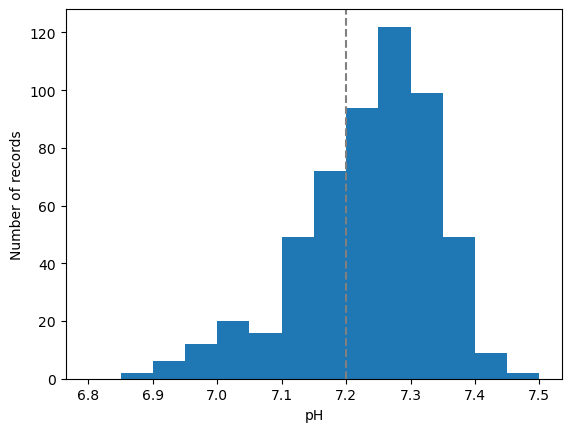

In [8]:
# Show distribution of outcome
plt.hist(metadata.loc[outcome], bins=np.arange(6.8, 7.5, 0.05))
plt.xlabel(outcome)
plt.ylabel('Number of records')
plt.axvline(x=outcome_threshold, color='grey', linestyle='--')

## Define x and y

In [9]:
# Set x as the signals from the dictionary
X = list(fhr_dict.values())

# Y is a boolean, true/false for each depending on outcome
# We set order of metadata according to dictionary keys so they match up
y = (metadata[fhr_dict.keys()].loc[outcome] < outcome_threshold).values

## Define training and testing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state=42)

## Scale data

In [11]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [12]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

n_classes = len(np.unique(y_train))

## Create model

2023-11-03 12:13:36.276024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 12:13:36.283334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 12:13:36.283631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

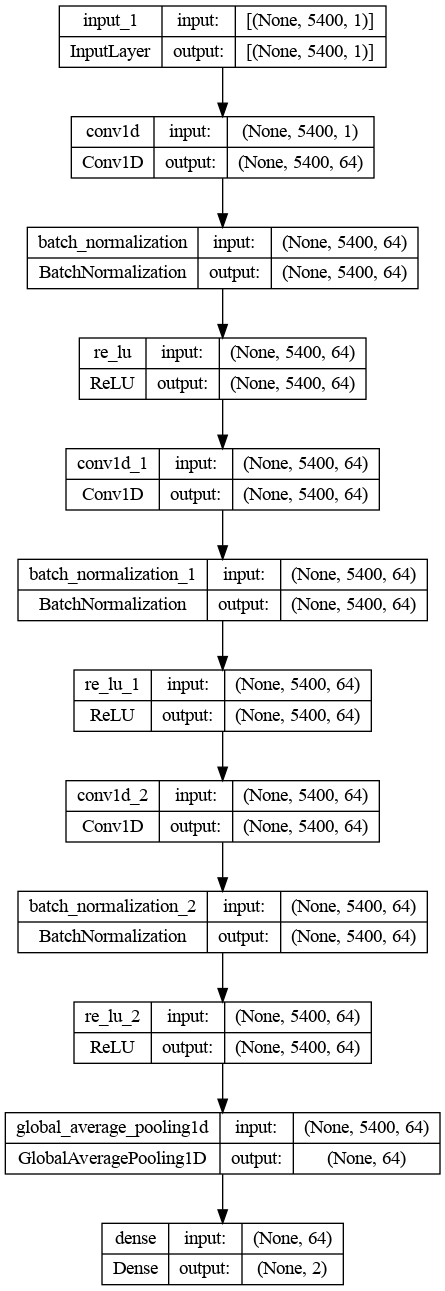

In [13]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    #conv3 = keras.layers.MaxPooling1D(pool_size=2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train_sc.shape[1:])
keras.utils.plot_model(model, show_shapes=True, to_file='outputs/model.png')

In [14]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "outputs/best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train_sc,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500


2023-11-03 12:13:40.772629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-03 12:13:42.764871: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b7800f160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 12:13:42.764911: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-11-03 12:13:42.774845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-03 12:13:42.922631: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 9s 183ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.6465 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 2/500
 2/11 [====>.........................] - ETA: 0s - loss: 0.6378 - sparse_categorical_accuracy: 0.7031

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 75ms/step - loss: 0.6182 - sparse_categorical_accuracy: 0.6858 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 3/500
11/11 [==============================] - 1s 73ms/step - loss: 0.6159 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 4/500
11/11 [==============================] - 1s 71ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.6367 - val_sparse_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 5/500
11/11 [==============================] - 1s 70ms/step - loss: 0.6115 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.6274 - val_sparse_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 6/500
11/11 [==============================] - 1s 69ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.6979 - val_loss: 0.6204 - val_sparse_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 7/500
11/11 [============================

## Evaluate performance

In [15]:
y_pred = model.predict(X_test_sc)[:,1]

5/5 [==============================] - 0s 45ms/step


In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print (f'AUC {roc_auc:0.4f}')

AUC 0.6975


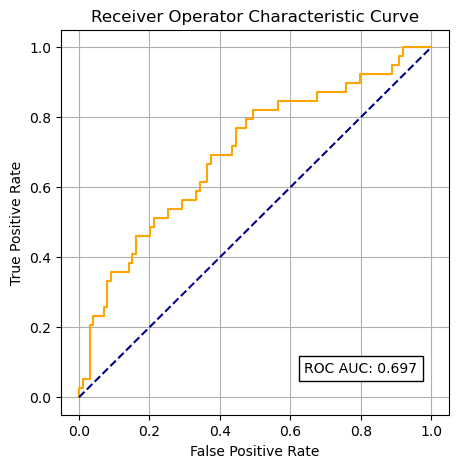

In [17]:
fig = plt.figure(figsize=(5,5))

# Plot ROC
ax1 = fig.add_subplot(111)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'ROC AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()

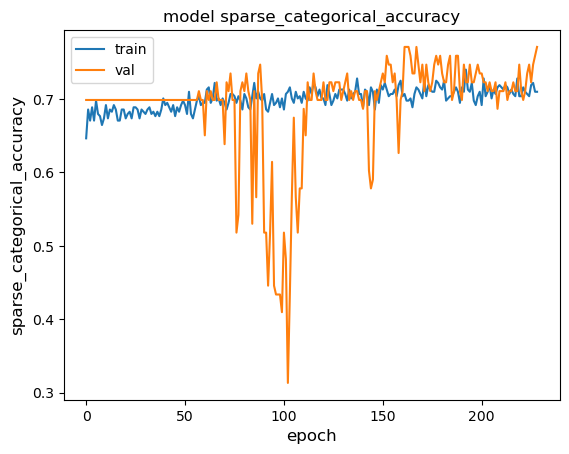

In [18]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()